In [180]:
import dask
dask.config.set({"dataframe.query-planning": False})

import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("../../../workflow/scripts/")
import readwrite
cfg = readwrite.config()

import geopandas as gpd
import shapely.geometry as sg
from shapely.strtree import STRtree
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def plot_polygon(ax, geometry, color, alpha=0.5):
    """Plots a Shapely geometry (Polygon, MultiPolygon, or Point) on a matplotlib Axes."""
    if geometry.is_empty:
        return  # Skip plotting empty geometries

    if geometry.geom_type == 'Polygon':
        patches = [Polygon(geometry.exterior.coords, closed=True)]
        collection = PatchCollection(patches, facecolor=color, edgecolor=color, alpha=alpha)
        ax.add_collection(collection)

    elif geometry.geom_type == 'MultiPolygon':
        patches = []
        for p in geometry.geoms:
            patches.append(Polygon(p.exterior.coords, closed=True))
        collection = PatchCollection(patches, facecolor=color, edgecolor=color, alpha=alpha)
        ax.add_collection(collection)

    elif geometry.geom_type == 'Point':
        ax.plot(geometry.x, geometry.y, marker='o', color=color, markersize=5, alpha=alpha)

    elif geometry.geom_type == 'GeometryCollection':
        # Plot the individual geometries within the collection
        for geom in geometry.geoms:
            plot_polygon(ax, geom, color, alpha) # Recursive call to plot each geometry

    else:
        print(f"Skipping unsupported geometry type: {geometry.geom_type}")
        return  # Skip plotting if it's not a supported type

    ax.autoscale_view()

import geopandas as gpd
import shapely.geometry as sg
from shapely.strtree import STRtree
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd

def plot_polygon(ax, geometry, color, alpha=0.5):
    """Plots a Shapely geometry (Polygon, MultiPolygon, or Point) on a matplotlib Axes."""
    if geometry.is_empty:
        return  # Skip plotting empty geometries

    if geometry.geom_type == 'Polygon':
        patches = [Polygon(geometry.exterior.coords, closed=True)]
        collection = PatchCollection(patches, facecolor=color, edgecolor=color, alpha=alpha)
        ax.add_collection(collection)

    elif geometry.geom_type == 'MultiPolygon':
        patches = []
        for p in geometry.geoms:
            patches.append(Polygon(p.exterior.coords, closed=True))
        collection = PatchCollection(patches, facecolor=color, edgecolor=color, alpha=alpha)
        ax.add_collection(collection)

    elif geometry.geom_type == 'Point':
        ax.plot(geometry.x, geometry.y, marker='o', color=color, markersize=5, alpha=alpha)

    elif geometry.geom_type == 'GeometryCollection':
        # Plot the individual geometries within the collection
        for geom in geometry.geoms:
            plot_polygon(ax, geom, color, alpha) # Recursive call to plot each geometry

    else:
        print(f"Skipping unsupported geometry type: {geometry.geom_type}")
        return  # Skip plotting if it's not a supported type

    ax.autoscale_view()

def intersecting_geometries_labeled(gdf1, gdf2):
    """
    Finds the intersections between all pairs of geometries from gdf1 and gdf2,
    labels them with the 'cell' identifiers, and returns the results in a DataFrame.
    Handles MultiPolygons directly without expansion.

    Args:
        gdf1 (geopandas.GeoDataFrame): The GeoDataFrame containing the geometries to check for intersections.
                                        Must have a 'geometry' column and a 'cell' column.
        gdf2 (geopandas.GeoDataFrame): The GeoDataFrame containing the geometries to use as search geometries.
                                        Must have a 'geometry' column and a 'cell' column.

    Returns:
        pandas.DataFrame: A DataFrame containing the intersections, labeled with the 'cell' identifiers
                          from both GeoDataFrames. The DataFrame has columns 'cell1', 'cell2', and 'intersection'.
                          Returns an empty DataFrame if there are no intersections.
    """

    if not all(col in gdf1.columns for col in ['geometry', 'cell']):
        raise ValueError("gdf1 must have 'geometry' and 'cell' columns")
    if not all(col in gdf2.columns for col in ['geometry', 'cell']):
        raise ValueError("gdf2 must have 'geometry' and 'cell' columns")

    # 1. Prepare geometries and cell labels from gdf1
    geometries1 = list(gdf1['geometry'])
    cell_labels1 = list(gdf1['cell'])

    # 2. Build STRtree using geometries from gdf1
    if not geometries1:
        return pd.DataFrame(columns=['cell1', 'cell2', 'intersection'])  # Return empty DataFrame

    tree = STRtree(geometries1)

    # 3. Prepare geometries and cell labels from gdf2
    geometries2 = list(gdf2['geometry'])
    cell_labels2 = list(gdf2['cell'])

    # 4. Perform the bulk query - all geometries from gdf2 at once
    possible_intersections_idx = tree.query(geometries2)

    # 5.  Process possible intersections
    intersection_data = []
    for i in range(len(possible_intersections_idx[0])):
      geom_index = possible_intersections_idx[1][i]
      index_two = possible_intersections_idx[0][i]

      if geom_index < len(geometries1) and index_two < len(geometries2): #Validate indexes to check

        geom1 = geometries1[geom_index]  # From gdf1
        geom2 = geometries2[index_two]  # From gdf2
        cell1 = cell_labels1[geom_index]
        cell2 = cell_labels2[index_two]

        if geom1.geom_type != 'Point' and geom2.geom_type != 'Point':  # Skip Point intersections

            intersection = geom2.intersection(geom1)  # Calculate intersection
            if not intersection.is_empty:
                intersection_data.append({
                    'cell1': cell1,
                    'cell2': cell2,
                    'intersection': intersection
                })

    # 6.  Create a DataFrame from the intersection data
    intersection_df = pd.DataFrame(intersection_data)
    return intersection_df

In [170]:
f1 = '/work/PRTNR/CHUV/DIR/rgottar1/single_cell_all/users/skang/Programming/img_registration/ihc_seg/transformed_coords/10x_5um_lung_0PSV.geojson.gz'
f2 = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/data/xenium_paper/xenium/processed/segmentation/proseg/NSCLC/lung/0PSV/0PSV/raw_results/cell-polygons.geojson.gz'

gdf1 = gpd.read_file("gzip://" +f1)
gdf2 = gpd.read_file("gzip://" +f2)

if 'cell' not in gdf1:
    gdf1['cell']=gdf1['id']
if 'cell' not in gdf2:
    gdf1['cell']=gdf1['id']

gdf2 = gdf2[:50]
gdf1 = gdf1[:10]

In [238]:
# --- Example Usage with GeoDataFrames ---

# Create sample GeoDataFrames (replace with your actual data)
data1 = {
    'cell': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'geometry': [
        sg.Polygon([(0, 0), (0, 2), (2, 2), (2, 0)]),
        sg.MultiPolygon([
            ([(3, 3), (3, 5), (5, 5), (5, 3)], []),
            ([(6, 1), (6, 2), (7, 2), (7, 1)], [])
        ]),
        sg.Point(5,5),
        sg.Polygon([(1, 1), (1, 3), (3, 3), (3, 1)]),
        sg.Polygon([(4, 4), (4, 6), (6, 6), (6, 4)]),
        sg.Polygon([(7, 7), (7, 9), (9, 9), (9, 7)]),
        sg.Polygon([(0, 4), (0, 6), (2, 6), (2, 4)]),
        sg.Polygon([(3, 7), (3, 9), (5, 9), (5, 7)]),
        sg.Polygon([(6, 4), (6, 6), (8, 6), (8, 4)]),
        sg.Polygon([(0, 7), (0, 9), (2, 9), (2, 7)])
    ]
}
gdf1 = gpd.GeoDataFrame(data1, crs="EPSG:4326")  # Add a CRS

data2 = {
    'cell': ['X', 'Y', 'Z'],
    'geometry': [
        sg.Polygon([(1, 1), (1, 3), (3, 3), (3, 1)]),
        sg.Polygon([(4, 4), (4, 6), (6, 6), (6, 4)]),
        sg.Polygon([(7, 7), (7, 9), (9, 9), (9, 7)])
    ]
}
gdf2 = gpd.GeoDataFrame(data2, crs="EPSG:4326")  # Add a CRS


In [253]:
# Perform spatial join to find intersecting pairs

joined = gpd.sjoin(gdf1, gdf2, how="inner", predicate="intersects",lsuffix='1', rsuffix='2')
gdf2['cell_2_']=gdf2['cell']
joined['cell_2_']=joined['cell_2']
joined = pd.merge(joined,gdf2,on=['cell_2_'],suffixes=('_1','_2'))

joined['intersection'] = joined.apply(lambda row: row['geometry_1'].intersection(row['geometry_2']), axis=1) # changed for more efficient

In [252]:
# Find labeled intersections for all pairs of geometries
intersection_df = intersecting_geometries_labeled(gdf1, gdf2)


Labeled Intersections:
  cell1 cell2                         intersection
0     A     X  POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))
1     D     X  POLYGON ((1 3, 3 3, 3 1, 1 1, 1 3))
2     B     X                          POINT (3 3)
3     B     Y  POLYGON ((4 5, 5 5, 5 4, 4 4, 4 5))
4     E     Y  POLYGON ((4 6, 6 6, 6 4, 4 4, 4 6))
5     I     Y                LINESTRING (6 6, 6 4)
6     F     Z  POLYGON ((7 9, 9 9, 9 7, 7 7, 7 9))


In [257]:
joined[['cell_1','cell_2','intersection']]

,cell_1,cell_2,intersection
0,A,X,"POLYGON ((2 2, 2 1, 1 1, 1 2, 2 2))"
1,B,X,POINT (3 3)
2,B,Y,"POLYGON ((5 5, 5 4, 4 4, 4 5, 5 5))"
3,C,Y,POINT (5 5)
4,D,X,"POLYGON ((1 3, 3 3, 3 1, 1 1, 1 3))"
5,E,Y,"POLYGON ((4 6, 6 6, 6 4, 4 4, 4 6))"
6,F,Z,"POLYGON ((7 9, 9 9, 9 7, 7 7, 7 9))"
7,I,Y,"LINESTRING (6 4, 6 6)"


In [254]:
intersection_df

,cell1,cell2,intersection
0,A,X,"POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))"
1,D,X,"POLYGON ((1 3, 3 3, 3 1, 1 1, 1 3))"
2,B,X,POINT (3 3)
3,B,Y,"POLYGON ((4 5, 5 5, 5 4, 4 4, 4 5))"
4,E,Y,"POLYGON ((4 6, 6 6, 6 4, 4 4, 4 6))"
5,I,Y,"LINESTRING (6 6, 6 4)"
6,F,Z,"POLYGON ((7 9, 9 9, 9 7, 7 7, 7 9))"


Skipping unsupported geometry type: LineString


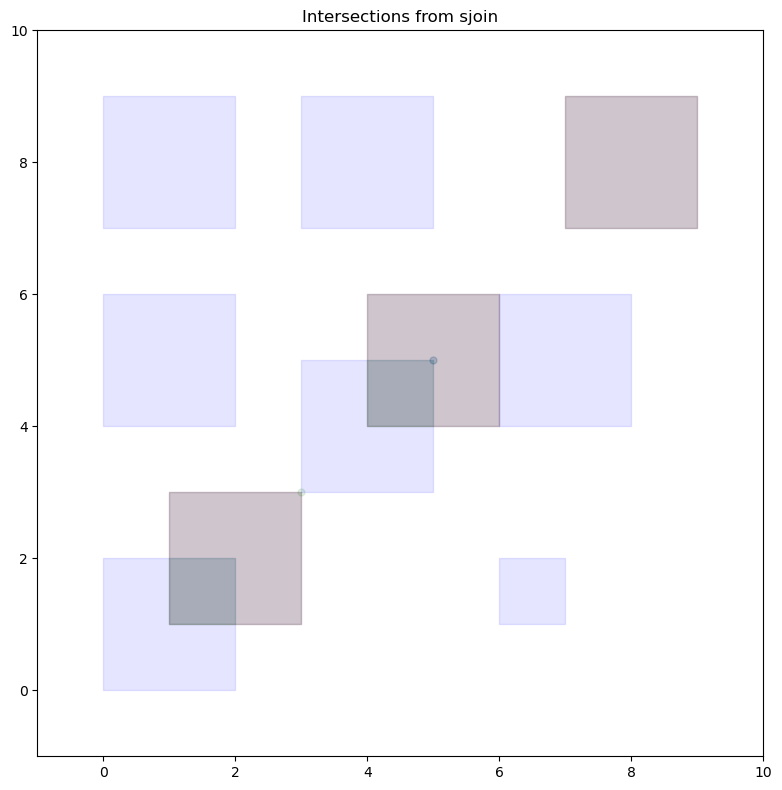


Joined DataFrame with Intersections:
  cell_1                                         geometry_1  index_2 cell_2  \
0      A                POLYGON ((0 0, 0 2, 2 2, 2 0, 0 0))        0      X   
1      B  MULTIPOLYGON (((3 3, 3 5, 5 5, 5 3, 3 3)), ((6...        0      X   
2      B  MULTIPOLYGON (((3 3, 3 5, 5 5, 5 3, 3 3)), ((6...        1      Y   
3      C                                        POINT (5 5)        1      Y   
4      D                POLYGON ((1 1, 1 3, 3 3, 3 1, 1 1))        0      X   
5      E                POLYGON ((4 4, 4 6, 6 6, 6 4, 4 4))        1      Y   
6      F                POLYGON ((7 7, 7 9, 9 9, 9 7, 7 7))        2      Z   
7      I                POLYGON ((6 4, 6 6, 8 6, 8 4, 6 4))        1      Y   

  cell_gdf2__1 cell_2_ cell                           geometry_2 cell_gdf2__2  \
0            X       X    X  POLYGON ((1 1, 1 3, 3 3, 3 1, 1 1))            X   
1            X       X    X  POLYGON ((1 1, 1 3, 3 3, 3 1, 1 1))            X   
2      

In [250]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Intersections from sjoin")

# Plot gdf1 geometries (blue)
for index, row in gdf1.iterrows():
    plot_polygon(ax, row['geometry'], 'blue', alpha=0.1)

# Plot gdf2 geometries (red)
for index, row in gdf2.iterrows():
    plot_polygon(ax, row['geometry'], 'red', alpha=0.1)

# Plot intersections (green)

for index, row in joined.iterrows():
    plot_polygon(ax, row['intersection'], 'green', alpha=.1)

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\nJoined DataFrame with Intersections:")
print(joined)

Skipping unsupported geometry type: LineString


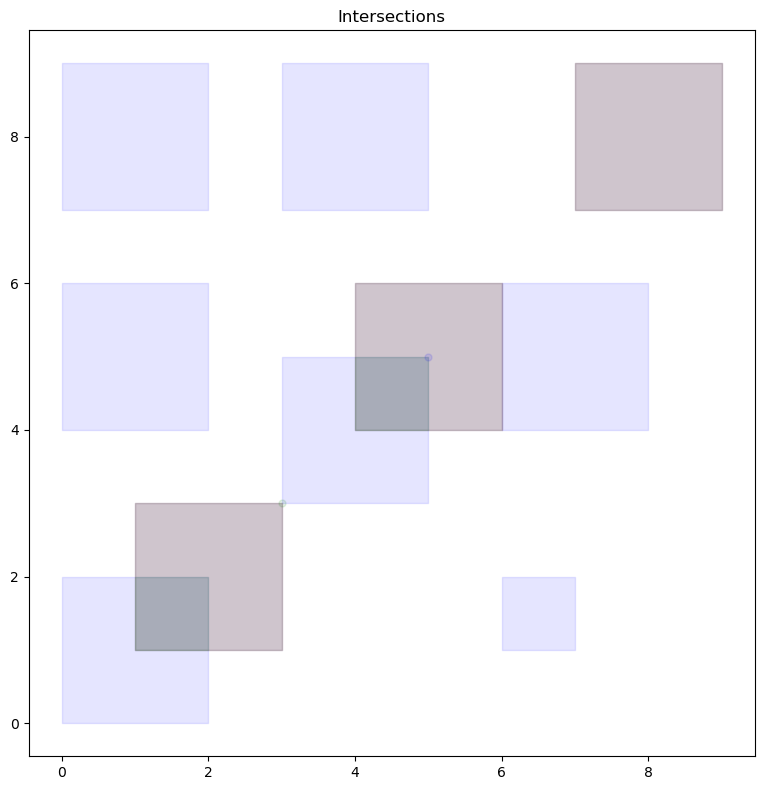

In [198]:
# Find labeled intersections for all pairs of geometries
intersection_df = intersecting_geometries_labeled(gdf2, gdf1)

# --- Plotting ---  Plot all intersections
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Intersections")

# Plot gdf1 geometries (blue)
for index, row in gdf1.iterrows():
    plot_polygon(ax, row['geometry'], 'blue', alpha=0.1)

# Plot gdf2 geometries (red)
for index, row in gdf2.iterrows():
    plot_polygon(ax, row['geometry'], 'red', alpha=0.1)

# Plot intersections (green)
for index, row in intersection_df.iterrows():
    plot_polygon(ax, row['intersection'], 'green', alpha=.1)

ax.set_aspect('equal')
plt.tight_layout()
plt.show()